# Virtual Try-On

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install required packages
!pip install -q torch torchvision
!pip install -q opencv-python
!pip install -q Pillow

In [169]:
# Import Libraries
import os
import json
from tqdm import tqdm
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset

In [5]:
# Copy dataset from drive and extract it
!cp drive/MyDrive/viton_resize.tar.gz viton_resize.tar.gz
!tar -xzf viton_resize.tar.gz

In [6]:
# Checking that the dataset has been successfully extracted
!ls -lh viton_resize/train/cloth | wc -l
!ls -lh viton_resize/train/cloth-mask | wc -l
!ls -lh viton_resize/train/image | wc -l
!ls -lh viton_resize/train/image-parse | wc -l
!ls -lh viton_resize/train/pose | wc -l

!ls -lh viton_resize/test/cloth | wc -l
!ls -lh viton_resize/test/cloth-mask | wc -l
!ls -lh viton_resize/test/image | wc -l
!ls -lh viton_resize/test/image-parse | wc -l
!ls -lh viton_resize/test/pose | wc -l

14222
14222
14222
14222
14222
2033
2033
2033
2033
2033


## Load Dataset

In [149]:
class VITONDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        self.cloth_dir = os.path.join(root_dir, mode, 'cloth')
        self.cloth_mask_dir = os.path.join(root_dir, mode, 'cloth-mask')
        self.image_dir = os.path.join(root_dir, mode, 'image')
        self.image_parse_dir = os.path.join(root_dir, mode, 'image-parse')
        self.pose_dir = os.path.join(root_dir, mode, 'pose')

        self.image_names = [f.split('_')[0] for f in os.listdir(self.image_dir)]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]

        # Update paths based on actual dataset structure
        cloth_path = os.path.join(self.cloth_dir, f"{image_name}_1.jpg")
        cloth_mask_path = os.path.join(self.cloth_mask_dir, f"{image_name}_1.jpg")
        image_path = os.path.join(self.image_dir, f"{image_name}_0.jpg")
        image_parse_path = os.path.join(self.image_parse_dir, f"{image_name}_0.png")
        pose_path = os.path.join(self.pose_dir, f"{image_name}_0_keypoints.json")

        # Open and convert images
        cloth_image = Image.open(cloth_path).convert('RGB')
        cloth_mask = Image.open(cloth_mask_path).convert('L')  # Convert to single-channel grayscale
        body_image = Image.open(image_path).convert('RGB')
        image_parse = Image.open(image_parse_path).convert('RGB')

        # Load and parse pose keypoints
        with open(pose_path, 'r') as f:
            pose_data = json.load(f)
            pose_keypoints = torch.tensor(pose_data['people'][0]['pose_keypoints']).view(-1, 3)

        # Apply transformations
        if self.transform:
            cloth_image = self.transform(cloth_image)
            cloth_mask = transforms.ToTensor()(cloth_mask)  # Convert mask to tensor
            cloth_mask = (cloth_mask > 0).float()  # Ensure mask values are 0 or 1
            body_image = self.transform(body_image)
            image_parse = self.transform(image_parse)

        return {
            'cloth_image': cloth_image,
            'cloth_mask': cloth_mask,
            'body_image': body_image,
            'image_parse': image_parse,
            'pose_keypoints': pose_keypoints
        }

In [150]:
# Prepare the Transformations
# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### Load ALL of Dataset

In [151]:
# Prepare the DataLoader
# Create dataset and dataloader
viton_dataset_path = './viton_resize'

train_dataset = VITONDataset(root_dir=viton_dataset_path, mode='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = VITONDataset(root_dir=viton_dataset_path, mode='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=True)

### Load just 30% of Dataset

In [10]:
# Create dataset paths
viton_dataset_path = './viton_resize'

# Create train dataset and select 30% of it
train_dataset = VITONDataset(root_dir=viton_dataset_path, mode='train', transform=transform)

# Calculate 30% of the dataset length
train_size = int(0.3 * len(train_dataset))

# Create a subset of the train dataset using the calculated size
train_indices = torch.randperm(len(train_dataset))[:train_size]  # Randomly sample indices
train_subset = Subset(train_dataset, train_indices)

# Create DataLoader for the train subset
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)

# Create test dataset and select 30% of it
test_dataset = VITONDataset(root_dir=viton_dataset_path, mode='test', transform=transform)

# Calculate 30% of the dataset length
test_size = int(0.3 * len(test_dataset))

# Create a subset of the test dataset using the calculated size
test_indices = torch.randperm(len(test_dataset))[:test_size]  # Randomly sample indices
test_subset = Subset(test_dataset, test_indices)

# Create DataLoader for the test subset
test_loader = DataLoader(test_subset, batch_size=3, shuffle=True)

In [11]:
def debug_dataloader(dataloader):
    for i, batch in enumerate(dataloader):
        print(f"Batch {i} shapes:")
        for key, value in batch.items():
            print(f"  {key}: {value.shape}")
        if i == 0:  # Only check the first batch
            break

debug_dataloader(train_loader)


Batch 0 shapes:
  cloth_image: torch.Size([16, 3, 256, 192])
  cloth_mask: torch.Size([16, 1, 256, 192])
  body_image: torch.Size([16, 3, 256, 192])
  image_parse: torch.Size([16, 3, 256, 192])
  pose_keypoints: torch.Size([16, 18, 3])


## Show Sample of dataset

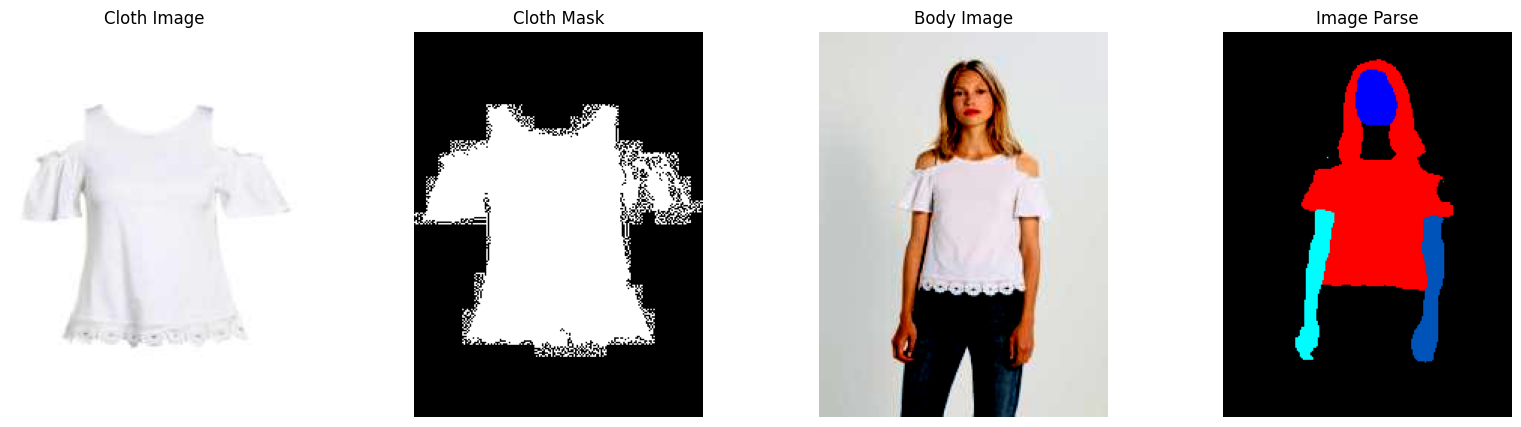

Pose Keypoints: tensor([[1.0054e+02, 4.5615e+01, 9.1018e-01],
        [1.0507e+02, 8.7040e+01, 7.9588e-01],
        [7.3827e+01, 8.6342e+01, 7.2157e-01],
        [6.5764e+01, 1.3824e+02, 8.1578e-01],
        [5.7953e+01, 1.8967e+02, 8.0022e-01],
        [1.3556e+02, 8.7738e+01, 7.0702e-01],
        [1.4035e+02, 1.4220e+02, 7.7338e-01],
        [1.3808e+02, 1.9200e+02, 7.9542e-01],
        [7.8614e+01, 1.7827e+02, 4.0504e-01],
        [6.6016e+01, 2.5530e+02, 2.7295e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.2019e+02, 1.7897e+02, 4.0888e-01],
        [1.1767e+02, 2.5577e+02, 2.3786e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.3732e+01, 4.0495e+01, 9.6575e-01],
        [1.0759e+02, 3.9331e+01, 9.3567e-01],
        [8.6677e+01, 4.7011e+01, 7.0944e-01],
        [1.1767e+02, 4.4218e+01, 7.5343e-01]])


In [12]:
def show_sample(dataset, idx):
    sample = dataset[idx]

    cloth_image = sample['cloth_image'].permute(1, 2, 0).numpy()  # [C, H, W] to [H, W, C]
    cloth_mask = sample['cloth_mask'].squeeze(0).numpy()  # Remove channel dimension
    body_image = sample['body_image'].permute(1, 2, 0).numpy()  # [C, H, W] to [H, W, C]
    image_parse = sample['image_parse'].permute(1, 2, 0).numpy()  # [C, H, W] to [H, W, C]
    pose_keypoints = sample['pose_keypoints']  # Pose keypoints are tensors

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(cloth_image)
    axs[0].set_title('Cloth Image')

    axs[1].imshow(cloth_mask, cmap='gray')
    axs[1].set_title('Cloth Mask')

    axs[2].imshow(body_image)
    axs[2].set_title('Body Image')

    axs[3].imshow(image_parse)
    axs[3].set_title('Image Parse')

    for ax in axs:
        ax.axis('off')

    plt.show()

    print("Pose Keypoints:", pose_keypoints)

# Visualize a sample from the train dataset
show_sample(train_dataset, idx=0)

## Model Architecture Design

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F

### Geometric Matching Module (GMM) with pose keypoints

In [153]:
from torch.nn import Parameter
from scipy.interpolate import Rbf

In [154]:
class PoseKeypointsExtractor(nn.Module):
    """
    PoseKeypointsExtractor: Extracts keypoints from the body image using CNN layers and fully connected layers.
    """
    def __init__(self):
        super(PoseKeypointsExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)

        # Adjust the size based on the feature map shape after conv layers
        # The shape before flattening is [batch_size, 256, 32, 24], so:
        self.fc1 = nn.Linear(256 * 32 * 24, 512)  # Adjusted input size for fc1 layer
        self.fc2 = nn.Linear(512, 18 * 2)  # 18 keypoints, each with (x, y) coordinates

    def forward(self, x):
        """
        Forward pass to extract keypoints from the body image.
        :param x: Input body image (tensor).
        :return: Predicted keypoints with shape (batch_size, 18, 2).
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten the feature map and adjust the size for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the tensor to (batch_size, features)
        x = F.relu(self.fc1(x))
        keypoints = self.fc2(x).view(-1, 18, 2)  # (batch_size, 18 keypoints, 2 coordinates)

        return keypoints


In [155]:
class SpatialTransformerNetwork(nn.Module):
    """
    Spatial Transformer Network (STN) that warps the clothing image based on keypoints
    using a Thin-Plate Spline (TPS) transformation.
    """

    def __init__(self, num_points=18):
        """
        Initialize the SpatialTransformerNetwork.

        Args:
            num_points (int): Number of keypoints (control points) used for TPS transformation.
        """
        super(SpatialTransformerNetwork, self).__init__()
        self.num_points = num_points
        # TPS control points are initialized randomly or using some fixed strategy.
        self.control_points = Parameter(torch.randn(num_points, 2))  # Random control points for cloth image

    def tps_warp(self, src_points, dst_points, cloth_image):
        """
        Apply Thin-Plate Spline (TPS) transformation to warp the clothing image based on keypoints.

        Args:
            src_points (Tensor): Source keypoints on the clothing image (batch_size, num_points, 2).
            dst_points (Tensor): Destination keypoints from the body image (batch_size, num_points, 2).
            cloth_image (Tensor): Clothing image to be warped (batch_size, C, H, W).

        Returns:
            warped_cloth (Tensor): Warped clothing image (batch_size, C, H, W).
        """
        batch_size, _, height, width = cloth_image.size()

        # Ensure source and destination points are of the same length
        if src_points.size(1) != self.num_points or dst_points.size(1) != self.num_points:
            raise ValueError(f"Expected {self.num_points} points, got {src_points.size(1)} and {dst_points.size(1)}.")

        # Convert PyTorch tensors to numpy arrays for RBF interpolation
        src_points_np = src_points.detach().cpu().numpy()  # Clothing keypoints (detached from computation graph)
        dst_points_np = dst_points.detach().cpu().numpy()  # Body keypoints (detached from computation graph)

        warped_images = []

        for i in range(batch_size):
            # Create meshgrid for the image (pixel coordinates)
            grid_x, grid_y = np.meshgrid(np.arange(width), np.arange(height))
            flat_grid = np.vstack([grid_x.flatten(), grid_y.flatten()]).T

            # Add small noise to avoid singular matrix error
            epsilon = 1e-5
            dst_points_np[i] += epsilon * np.random.randn(*dst_points_np[i].shape)

            # Apply TPS using Rbf (Radial Basis Function) with smooth regularization to avoid singular matrix
            rbf_x = Rbf(dst_points_np[i, :, 0], dst_points_np[i, :, 1], src_points_np[i, :, 0], function='thin_plate', smooth=epsilon)
            rbf_y = Rbf(dst_points_np[i, :, 0], dst_points_np[i, :, 1], src_points_np[i, :, 1], function='thin_plate', smooth=epsilon)

            warped_grid_x = rbf_x(flat_grid[:, 0], flat_grid[:, 1])
            warped_grid_y = rbf_y(flat_grid[:, 0], flat_grid[:, 1])

            warped_grid_x = np.clip(warped_grid_x, 0, width - 1).reshape(height, width)
            warped_grid_y = np.clip(warped_grid_y, 0, height - 1).reshape(height, width)

            # Warp each channel of the clothing image using bilinear interpolation
            warped_image = np.zeros_like(cloth_image[i].cpu().numpy())

            for c in range(cloth_image.size(1)):  # For each color channel
                warped_image[c] = self.bilinear_interpolate(cloth_image[i, c].cpu().numpy(), warped_grid_x, warped_grid_y)

            warped_images.append(warped_image)

        # Convert warped images back to a PyTorch tensor
        warped_images = torch.tensor(warped_images).float().to(cloth_image.device)

        return warped_images

    @staticmethod
    def bilinear_interpolate(im, x, y):
        """
        Bilinear interpolation to sample pixel values from the original image.

        Args:
            im (ndarray): Original image (H, W).
            x (ndarray): X-coordinates of the grid to sample from.
            y (ndarray): Y-coordinates of the grid to sample from.

        Returns:
            ndarray: Warped image based on the interpolated pixel values.
        """
        x0 = np.floor(x).astype(int)
        x1 = x0 + 1
        y0 = np.floor(y).astype(int)
        y1 = y0 + 1

        x0 = np.clip(x0, 0, im.shape[1] - 1)
        x1 = np.clip(x1, 0, im.shape[1] - 1)
        y0 = np.clip(y0, 0, im.shape[0] - 1)
        y1 = np.clip(y1, 0, im.shape[0] - 1)

        Ia = im[y0, x0]
        Ib = im[y1, x0]
        Ic = im[y0, x1]
        Id = im[y1, x1]

        wa = (x1 - x) * (y1 - y)
        wb = (x1 - x) * (y - y0)
        wc = (x - x0) * (y1 - y)
        wd = (x - x0) * (y - y0)

        return wa * Ia + wb * Ib + wc * Ic + wd * Id

    def forward(self, cloth_image, keypoints):
        """
        Forward pass for the STN.

        Args:
            cloth_image (Tensor): Input clothing image (batch_size, C, H, W).
            keypoints (Tensor): Destination keypoints from the body image (batch_size, num_points, 2).

        Returns:
            warped_cloth (Tensor): Warped clothing image.
        """
        # Source points for the cloth: control points initialized or learned
        src_points = self.control_points.unsqueeze(0).repeat(cloth_image.size(0), 1, 1).to(cloth_image.device)
        dst_points = keypoints

        # Perform TPS warping
        warped_cloth = self.tps_warp(src_points, dst_points, cloth_image)

        return warped_cloth


In [156]:
class GMM(nn.Module):
    """
    GMM: Geometric Matching Module that warps the clothing image based
    on pose keypoints.

    The module uses a Spatial Transformer Network (STN) to warp the clothing
    image according to the body pose represented by keypoints.
    """
    def __init__(self):
        super(GMM, self).__init__()
        self.stn = SpatialTransformerNetwork()

    def forward(self, cloth_image, body_image):
        """
        Forward pass for GMM.
        :param cloth_image: Clothing image tensor.
        :param body_image: Body image tensor.
        :return: Warped clothing image tensor.
        """
        # Step 1: Extract keypoints from the body image
        keypoints_extractor = PoseKeypointsExtractor().to(next(self.parameters()).device)
        body_keypoints = keypoints_extractor(body_image)

        # Step 2: Use the keypoints in the STN to warp the clothing image
        warped_cloth = self.stn(cloth_image, body_keypoints)

        return warped_cloth


### UNet for Segmentation

In [157]:
class SegNet(nn.Module):
    """
    UNet-based segmentation network that generates a segmentation mask for the body.
    The input consists of the body image and the warped cloth image, and the output is a binary mask
    indicating where the clothing should appear on the person.

    Args:
        input_channels (int): Number of input channels, including the body image and warped cloth
        output_channels (int): Number of output channels, typically 1 for binary mask

    Input:
        x (Tensor): Concatenated input tensor of the body image and warped cloth (batch_size, input_channels, H, W)

    Output:
        mask (Tensor): Segmentation mask for the body (batch_size, 1, H, W), values between 0 and 1
    """
    def __init__(self, input_channels=6, output_channels=1):
        super(SegNet, self).__init__()

        # Encoder layers (downsampling path)
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (batch_size, 128, H/4, W/4)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (batch_size, 256, H/8, W/8)
            nn.ReLU()
        )

        # Decoder layers (upsampling path)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # (batch_size, 128, H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, output_channels, kernel_size=4, stride=2, padding=1),  # (batch_size, 1, H, W)
            nn.Sigmoid()  # Sigmoid ensures output is in range [0, 1]
        )

    def forward(self, x):
        # Pass input through encoder and decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # Final output is already sigmoid-activated


### Composition Network

In [158]:
class CompNet(nn.Module):
    """
    Composition Network that combines the body image, warped cloth, and segmentation mask
    to produce the final try-on result (person wearing the new cloth).

    Args:
        None

    Input:
        body_image (Tensor): The body image of the person (batch_size, 3, H, W)
        warped_cloth (Tensor): The warped cloth image (batch_size, 3, H, W)
        segmentation_mask (Tensor): The segmentation mask indicating clothing regions (batch_size, 1, H, W)

    Output:
        output (Tensor): The final composite image (batch_size, 3, H, W)
    """
    def __init__(self):
        super(CompNet, self).__init__()

        # Composition layers that combine body image, warped cloth, and mask
        self.network = nn.Sequential(
            nn.Conv2d(7, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (batch_size, 128, H/4, W/4)
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # (batch_size, 64, H/2, W/2)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # (batch_size, 3, H, W)
            nn.Tanh()  # Final output in range [-1, 1] for RGB image
        )

    def forward(self, body_image, warped_cloth, segmentation_mask):
        # Concatenate body image, warped cloth, and segmentation mask along the channel dimension
        input_tensor = torch.cat([body_image, warped_cloth, segmentation_mask], dim=1)

        # Pass through the composition network
        output = self.network(input_tensor)
        return output


## Virtual Try-on Model

In [159]:
class VirtualTryOnModel(nn.Module):
    """
    Virtual Try-On model using pose keypoints for training and predicted keypoints for inference.
    """
    def __init__(self, use_keypoints=True):
        super(VirtualTryOnModel, self).__init__()
        self.use_keypoints = use_keypoints
        self.tps_net = SpatialTransformerNetwork()
        self.gmm = GMM()  # GMM includes the Spatial Transformer Network
        self.segnet = SegNet()
        self.compnet = CompNet()
        if not self.use_keypoints:
            self.keypoint_predictor = PoseKeypointsExtractor()  # Predicts keypoints during inference
            self.keypoint_predictor.to(next(self.parameters()).device)

    def forward(self, cloth_image, body_image, body_keypoints=None):
        """
        Forward pass: uses keypoints for training and predicts keypoints during inference.
        """
        if self.use_keypoints:
            # Training: Use provided keypoints
            warped_cloth = self.tps_net(cloth_image, body_keypoints)
        else:
            # Inference: Predict keypoints
            predicted_keypoints = self.keypoint_predictor(body_image)
            warped_cloth = self.tps_net(cloth_image, predicted_keypoints)

        refined_cloth = self.gmm(body_image, warped_cloth)
        seg_input = torch.cat([body_image, refined_cloth], dim=1)
        segmentation_mask = self.segnet(seg_input)
        final_output = self.compnet(body_image, refined_cloth, segmentation_mask)

        return final_output, warped_cloth, refined_cloth, segmentation_mask


## Training the Virtual Try-On Model

### Loss Functions

In [160]:
import torch.nn.functional as F
from torchvision import models

In [161]:
# L1 Loss for warping
# During inference, keypoint_loss is not included
def warp_loss(warped_cloth, target_cloth, body_keypoints=None, predicted_keypoints=None):
    l1_loss = F.l1_loss(warped_cloth, target_cloth)
    if body_keypoints is not None and predicted_keypoints is not None:
        keypoint_loss = F.mse_loss(predicted_keypoints, body_keypoints)
        total_loss = l1_loss + keypoint_loss
    else:
        total_loss = l1_loss  # Inference mode only uses L1 loss
    return total_loss


# Cross-Entropy Loss for segmentation
def segmentation_loss(pred_mask, target_mask):
    """
    Compute Cross-Entropy loss for segmentation mask.

    Args:
        pred_mask (Tensor): Predicted segmentation mask (batch_size, 1, H, W)
        target_mask (Tensor): Ground truth segmentation mask (batch_size, 1, H, W)

    Returns:
        loss (Tensor): Cross-Entropy loss value
    """
    return F.binary_cross_entropy(pred_mask, target_mask)


def keypoint_loss(predicted_keypoints, target_keypoints):
    """
    Calculates the keypoint prediction loss (L2 loss).

    :param predicted_keypoints: Predicted keypoints from the KeypointPredictor.
    :param target_keypoints: Ground truth keypoints.
    :return: Keypoint prediction loss.
    """
    return F.mse_loss(predicted_keypoints, target_keypoints)


# Perceptual Loss using a pre-trained VGG model
class PerceptualLoss(nn.Module):
    """
    Perceptual loss compares high-level features extracted from a pre-trained VGG model.
    This helps improve the visual quality of the final composite image.

    Args:
        None
    """
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features[:16].eval()  # Use the first few layers of VGG19
        for param in vgg.parameters():
            param.requires_grad = False  # Freeze VGG parameters
        self.vgg = vgg

    def forward(self, pred_img, target_img):
        # Normalize the images for VGG
        pred_img = (pred_img + 1) / 2  # Normalize to [0, 1]
        target_img = (target_img + 1) / 2
        features_pred = self.vgg(pred_img)
        features_target = self.vgg(target_img)
        perceptual_loss = F.l1_loss(features_pred, features_target)
        return perceptual_loss


def compute_total_loss(warp_l1, seg_loss, perceptual_loss, keypoint_loss=None):
    """
    Combines individual losses to compute the total loss.

    :param warp_l1: Warp L1 loss from GMM.
    :param seg_loss: Segmentation loss from SegNet.
    :param perceptual_loss: Perceptual loss for image quality.
    :param keypoint_loss: (Optional) Keypoint loss, used only during training keypoint prediction.
    :return: Total loss.
    """
    total_loss = warp_l1 + seg_loss + perceptual_loss

    if keypoint_loss is not None:
        total_loss += keypoint_loss

    return total_loss

### Optimization

In [162]:
import torch.optim as optim

In [163]:
# Define the optimizers for each component of the model
def create_optimizers(model, lr=0.001):
    """
    Creates optimizers for the different components of the VirtualTryOnModel.

    Args:
        model: The VirtualTryOnModel instance.
        lr: Learning rate for the optimizers.

    Returns:
        A dictionary of optimizers for each component of the model.
    """
    optimizers = {
        'gmm': torch.optim.Adam(model.gmm.parameters(), lr=lr),
        'seg_net': torch.optim.Adam(model.segnet.parameters(), lr=lr),
        'comp_net': torch.optim.Adam(model.compnet.parameters(), lr=lr),
        'tps_net': torch.optim.Adam(model.tps_net.parameters(), lr=lr)
    }
    if not model.use_keypoints:
        optimizers['keypoint_predictor'] = torch.optim.Adam(model.keypoint_predictor.parameters(), lr=lr)
    return optimizers


### Training the Model and Saving the Checkpoints

In [164]:
import os
import torch

In [170]:
def train_vton_and_save(model, dataloader, num_epochs=20, device='cuda', save_dir='./model_checkpoints', start_epoch=0):
    """
    Training loop for the Virtual Try-On model with model saving functionality.

    The function trains the model using pose keypoints during training, and ensures the
    correct handling of the absence of keypoints during inference.

    Args:
        model (VirtualTryOnModel): The virtual try-on model combining GMM, SegNet, and CompNet.
        dataloader (DataLoader): DataLoader for training data.
        num_epochs (int): Number of epochs for training.
        device (str): Device to use for training ('cuda' or 'cpu').
        save_dir (str): Directory to save the trained models.
        start_epoch (int): The epoch to resume training from.

    Returns:
        tuple: Trained model and optimizer state for resuming training later.
    """
    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Move model to the device
    model.to(device)

    # Loss functions
    perceptual_loss_fn = PerceptualLoss().to(device)

    # Create optimizers
    optimizers = create_optimizers(model)

    final_total_loss = None

    for epoch in tqdm(range(start_epoch, num_epochs)):
        model.train()

        epoch_total_loss = 0.0  # Accumulate total loss for the epoch

        for batch in dataloader:
            body_image = batch['body_image'].to(device)
            cloth_image = batch['cloth_image'].to(device)
            cloth_mask = batch['cloth_mask'].to(device)

            if model.use_keypoints:
                pose_keypoints = batch['pose_keypoints'].to(device)
                final_output, warped_cloth, refined_cloth, segmentation_mask = model(
                    cloth_image, body_image, body_keypoints=pose_keypoints)
            else:
                final_output, warped_cloth, refined_cloth, segmentation_mask = model(
                    cloth_image, body_image)

            # Loss calculations
            warp_l1 = warp_loss(warped_cloth, cloth_image, pose_keypoints if model.use_keypoints else None)

            # # Ensure the segmentation_mask is passed through a sigmoid
            # segmentation_mask = torch.sigmoid(segmentation_mask)
            # # compute the segmentation loss
            # seg_loss = segmentation_loss(segmentation_mask.mean(dim=1, keepdim=True), cloth_mask)

            seg_loss = segmentation_loss(segmentation_mask, cloth_mask)

            perceptual_loss = perceptual_loss_fn(final_output, body_image)

            total_loss = compute_total_loss(warp_l1, seg_loss, perceptual_loss)

            epoch_total_loss += total_loss.item()

            # Backpropagation and optimization
            for optimizer in optimizers.values():
                optimizer.zero_grad()

            total_loss.backward()

            for optimizer in optimizers.values():
                optimizer.step()

        final_total_loss = epoch_total_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {final_total_loss:.4f}")

        # Save model checkpoints after each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, f'vton_model_epoch_{epoch + 1}.pth'))
        torch.save({name: opt.state_dict() for name, opt in optimizers.items()},
                   os.path.join(save_dir, f'optimizers_epoch_{epoch + 1}.pth'))

    print("Training complete! Models saved in:", save_dir)
    return model, optimizers, final_total_loss


#### Training loop

In [171]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

 We do not run these cells if we train this model once

Run these cells for first time traing model

In [172]:
# Instantiate the model
model = VirtualTryOnModel().to(device)

# Define the number of epochs and other training parameters
num_epochs = 1
save_dir = './model_checkpoints'

In [173]:
# Train the model for the first phase (e.g., 20 epoch)
model, optimizers, final_total_loss = train_vton_and_save(
    model,
    dataloader=train_loader,
    num_epochs=num_epochs,
    device=device,
    save_dir=save_dir
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 1/1 [1:09:25<00:00, 4165.29s/it]

Epoch [1/1], Loss: 1.3884
Training complete! Models saved in: ./model_checkpoints


In [174]:
print(f"Final total loss after training: {final_total_loss:.4f}")

Final total loss after training: 1.3884


#### Saving Optimizer States

In [175]:
# Save the optimizer states for resuming training later
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizers_state_dict': {name: optimizer.state_dict() for name, optimizer in optimizers.items()},
    'final_loss': final_total_loss,
}

# Save the checkpoint
torch.save(checkpoint, os.path.join(save_dir, 'checkpoint.pth'))
print(f"Checkpoint saved to {save_dir}/checkpoint.pth")

Checkpoint saved to ./model_checkpoints/checkpoint.pth


In [177]:
!ls -alh model_checkpoints/

total 37M
drwxr-xr-x 2 root root 4.0K Oct 11 00:43 .
drwxr-xr-x 1 root root 4.0K Oct 10 22:42 ..
-rw-r--r-- 1 root root  19M Oct 11 00:43 checkpoint.pth
-rw-r--r-- 1 root root  13M Oct 11 00:42 optimizers_epoch_1.pth
-rw-r--r-- 1 root root 6.1M Oct 11 00:42 vton_model_epoch_1.pth


End of first time traing model

#### Loading the Model for Future Training

Download the model_checkpoints.zip file from [here]() with 1 epochs

In [ ]:
# copy model checkpoints zip file from drive and unzip it
!cp drive/MyDrive/model_checkpoints.zip ./model_checkpoints.zip
!unzip model_checkpoints.zip

In [183]:
save_dir = './model_checkpoints'

# Load the checkpoint
checkpoint = torch.load(os.path.join(save_dir, 'checkpoint.pth'))

# Instantiate the model again
model = VirtualTryOnModel().to(device)

# Load the model state
model.load_state_dict(checkpoint['model_state_dict'])

# Create optimizers again
optimizers = create_optimizers(model)

# Load the optimizer states
for name, optimizer in optimizers.items():
    optimizer.load_state_dict(checkpoint['optimizers_state_dict'][name])

# Set the epoch to resume training from
start_epoch = checkpoint['epoch']
print(f"Resuming training from epoch {start_epoch}")

# Verify that the model is on the correct device
print(f"Model device: {next(model.parameters()).device}")

# Set the epoch to resume training from
start_epoch = checkpoint['epoch']
print(f"Resuming training from epoch {start_epoch}")

# Verify optimizer loading by printing state of one optimizer
for name, optimizer in optimizers.items():
    print(f"Optimizer: {name}, Loaded state dict keys: {optimizer.state_dict().keys()}")

# Test forward pass with dummy data to check model functionality
with torch.no_grad():  # Use no_grad to avoid affecting gradient computations
    # Create dummy input tensors
    dummy_cloth_image = torch.randn(1, 3, 256, 192).to(device)
    dummy_body_image = torch.randn(1, 3, 256, 192).to(device)
    dummy_pose_keypoints = torch.randn(1, 18, 2).to(device)

    # Run a forward pass to check if the model runs without errors
    final_output, warped_cloth, refined_cloth, segmentation_mask = model(dummy_cloth_image, dummy_body_image, body_keypoints=dummy_pose_keypoints)

    print("Model forward pass successful.")

<ipython-input-183-28f8c32e388e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(save_dir, 'checkpoint.pth'))


Resuming training from epoch 1
Model device: cuda:0
Resuming training from epoch 1
Optimizer: gmm, Loaded state dict keys: dict_keys(['state', 'param_groups'])
Optimizer: seg_net, Loaded state dict keys: dict_keys(['state', 'param_groups'])
Optimizer: comp_net, Loaded state dict keys: dict_keys(['state', 'param_groups'])
Optimizer: tps_net, Loaded state dict keys: dict_keys(['state', 'param_groups'])
Model forward pass successful.


In [ ]:
# Continue training from the loaded state for more epochs (e.g., 10 more epochs)
model, optimizers, final_total_loss = train_vton_and_save(
    model,
    dataloader=train_loader,
    num_epochs=30,
    device=device,
    save_dir=save_dir,
    start_epoch=start_epoch
)

In [ ]:
print(f"Final total loss after training: {final_total_loss:.4f}")

In [ ]:
# Save the optimizer states for resuming training later
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizers_state_dict': {name: optimizer.state_dict() for name, optimizer in optimizers.items()},
    'final_loss': final_total_loss,
}

# Save the checkpoint
torch.save(checkpoint, os.path.join(save_dir, 'checkpoint.pth'))
print(f"Checkpoint saved to {save_dir}/checkpoint.pth")

In [ ]:
# Check to see list of model checkpoints
!ls model_checkpoints/

In [ ]:
# Remove old model checkpoints files
!rm -rf model_checkpoints/comp_net_epoch_100.pth	model_checkpoints/gmm_epoch_100.pth model_checkpoints/seg_net_epoch_100.pth

In [ ]:
def delete_files(start_num, end_num, directory, name, ext):
    for filename in os.listdir(directory):
        if filename.startswith(name) and filename.endswith(ext):
            file_num = int(filename.replace(ext, '').split('_')[-1])
            if start_num <= file_num <= end_num:
                file_path = os.path.join(directory, filename)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

start_number = 1
end_number = 49
target_directory = "./model_checkpoints"
ext = ".pth"

delete_files(start_number, end_number, target_directory, "comp_net_epoch_", ext)
delete_files(start_number, end_number, target_directory, "gmm_epoch_", ext)
delete_files(start_number, end_number, target_directory, "seg_net_epoch_", ext)

In [ ]:
# Remove unneccesary files
!rm -rf model_checkpoints.zip
!rm -rf model_checkpoints/checkpoint_epoch_100.pth

In [ ]:
# Rename models based on last epoch
!mv model_checkpoints/seg_net_epoch_50.pth model_checkpoints/seg_net_epoch_150.pth
!mv model_checkpoints/comp_net_epoch_50.pth model_checkpoints/comp_net_epoch_150.pth
!mv model_checkpoints/gmm_epoch_50.pth model_checkpoints/gmm_epoch_150.pth

In [ ]:
# Check the list of model checkpoints
!ls model_checkpoints/

In [178]:
import zipfile
import shutil

def zip_directory(directory_path, zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(directory_path):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(directory_path))
                zipf.write(file_path, arcname)

In [179]:
zip_directory('./model_checkpoints', 'model_checkpoints.zip')
shutil.copy('model_checkpoints.zip', 'drive/MyDrive/model_checkpoints.zip')

'drive/MyDrive/model_checkpoints.zip'

## Evaluation and Inference

### Evaluation Function

In [184]:
def evaluate_vton(model, dataloader, device, save_dir='./model_checkpoints', checkpoint_file='checkpoint.pth'):
    """
    Function to evaluate the Virtual Try-On model on a validation/test dataset.

    Args:
        model (VirtualTryOnModel): The virtual try-on model to evaluate.
        dataloader (DataLoader): DataLoader for the validation/test data.
        device (str): Device to run the evaluation on ('cuda' or 'cpu').
        save_dir (str): Directory where the model checkpoint is saved.
        checkpoint_file (str): Name of the checkpoint file to load for evaluation.

    Returns:
        evaluation_metrics (dict): A dictionary of evaluation metrics, such as pixel accuracy or loss.
    """

    # Load the checkpoint (model state only, not optimizers since we're evaluating)
    checkpoint_path = os.path.join(save_dir, checkpoint_file)
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set model to evaluation mode (disables dropout, batchnorm, etc.)

    # Initialize metrics for evaluation
    total_loss = 0.0
    perceptual_loss_fn = PerceptualLoss().to(device)  # Assume this loss is used
    total_perceptual_loss = 0.0
    total_batches = 0

    # Loop through the evaluation dataset
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in dataloader:
            body_image = batch['body_image'].to(device)
            cloth_image = batch['cloth_image'].to(device)
            cloth_mask = batch['cloth_mask'].to(device)

            if model.use_keypoints:
                pose_keypoints = batch['pose_keypoints'].to(device)
                final_output, warped_cloth, refined_cloth, segmentation_mask = model(
                    cloth_image, body_image, body_keypoints=pose_keypoints)
            else:
                final_output, warped_cloth, refined_cloth, segmentation_mask = model(
                    cloth_image, body_image)

            # Compute loss or evaluation metrics (replace with your actual evaluation logic)
            warp_l1_loss = warp_loss(warped_cloth, cloth_image, pose_keypoints if model.use_keypoints else None)
            seg_loss = segmentation_loss(segmentation_mask, cloth_mask)
            perceptual_loss = perceptual_loss_fn(final_output, body_image)

            # Combine losses (if you're using a combined loss for evaluation)
            total_loss += warp_l1_loss.item() + seg_loss.item() + perceptual_loss.item()
            total_perceptual_loss += perceptual_loss.item()
            total_batches += 1

    # Calculate average loss over all batches
    avg_loss = total_loss / total_batches if total_batches > 0 else 0
    avg_perceptual_loss = total_perceptual_loss / total_batches if total_batches > 0 else 0

    # Return evaluation metrics
    evaluation_metrics = {
        'average_loss': avg_loss,
        'average_perceptual_loss': avg_perceptual_loss
    }

    print(f"Evaluation complete. Average Loss: {avg_loss:.4f}, Perceptual Loss: {avg_perceptual_loss:.4f}")
    return evaluation_metrics


In [185]:
# Evaluate the model
evaluation_metrics = evaluate_vton(model, test_loader, device=device)
print("Evaluation Results:", evaluation_metrics)

<ipython-input-184-edecfd5ff787>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.10/di

Evaluation complete. Average Loss: 1.2136, Perceptual Loss: 0.1377
Evaluation Results: {'average_loss': 1.2136301505145861, 'average_perceptual_loss': 0.13765327922538317}


### Inference and Visualization

In [191]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import os

def visualize_vton_results(model, dataloader, device, num_images=5, save_dir='./visualizations', checkpoint_file='checkpoint.pth'):
    """
    Visualizes the results of the Virtual Try-On model on a few examples from the validation/test dataset.

    Args:
        model (VirtualTryOnModel): The virtual try-on model to visualize.
        dataloader (DataLoader): DataLoader for the validation/test data.
        device (str): Device to run the evaluation on ('cuda' or 'cpu').
        num_images (int): Number of images to visualize.
        save_dir (str): Directory where the visualizations will be saved.
        checkpoint_file (str): Name of the checkpoint file to load for visualization.

    Returns:
        None: Saves and displays the visualizations.
    """

    # Load the checkpoint (model state only, not optimizers since we're only visualizing)
    checkpoint_path = os.path.join(save_dir, checkpoint_file)
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load the model state
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Create the save directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    # Visualize num_images
    images_visualized = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            body_image = batch['body_image'].to(device)
            cloth_image = batch['cloth_image'].to(device)

            if model.use_keypoints:
                pose_keypoints = batch['pose_keypoints'].to(device)
                final_output, warped_cloth, refined_cloth, segmentation_mask = model(
                    cloth_image, body_image, body_keypoints=pose_keypoints)
            else:
                final_output, warped_cloth, refined_cloth, segmentation_mask = model(
                    cloth_image, body_image)

            # Convert tensors to CPU and prepare for visualization
            body_image = body_image.cpu()
            cloth_image = cloth_image.cpu()
            final_output = final_output.cpu()
            warped_cloth = warped_cloth.cpu()

            # Visualize a grid of input and output images for comparison
            for i in range(body_image.size(0)):
                if images_visualized >= num_images:
                    return  # Stop once we've visualized the required number of images

                # Prepare figure
                fig, axs = plt.subplots(1, 4, figsize=(15, 5))
                fig.suptitle(f"Example {images_visualized + 1}", fontsize=16)

                # Visualize body image
                axs[0].imshow(vutils.make_grid(body_image[i], normalize=True, scale_each=True).permute(1, 2, 0))
                axs[0].set_title('Body Image')
                axs[0].axis('off')

                # Visualize cloth image
                axs[1].imshow(vutils.make_grid(cloth_image[i], normalize=True, scale_each=True).permute(1, 2, 0))
                axs[1].set_title('Cloth Image')
                axs[1].axis('off')

                # Visualize warped cloth image
                axs[2].imshow(vutils.make_grid(warped_cloth[i], normalize=True, scale_each=True).permute(1, 2, 0))
                axs[2].set_title('Warped Cloth')
                axs[2].axis('off')

                # Visualize final output (virtual try-on)
                axs[3].imshow(vutils.make_grid(final_output[i], normalize=True, scale_each=True).permute(1, 2, 0))
                axs[3].set_title('Final Try-On')
                axs[3].axis('off')

                # Save the figure
                plt.savefig(os.path.join(save_dir, f'visualization_{images_visualized + 1}.png'))

                # Show the figure (so it displays in the output)
                plt.show()

                images_visualized += 1

                if images_visualized >= num_images:
                    break  # Stop if we've visualized enough images

    print(f"Visualizations saved in {save_dir}")


<ipython-input-191-edac18f72b69>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


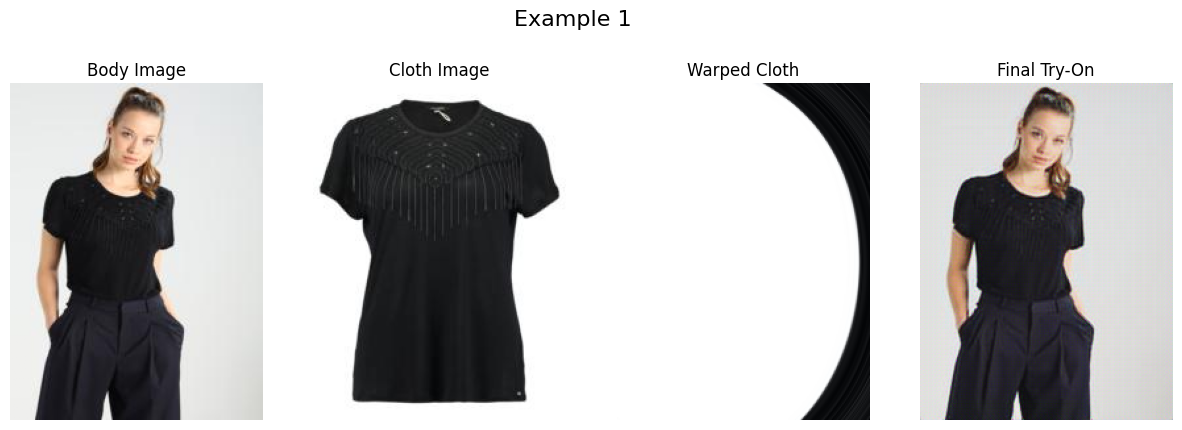

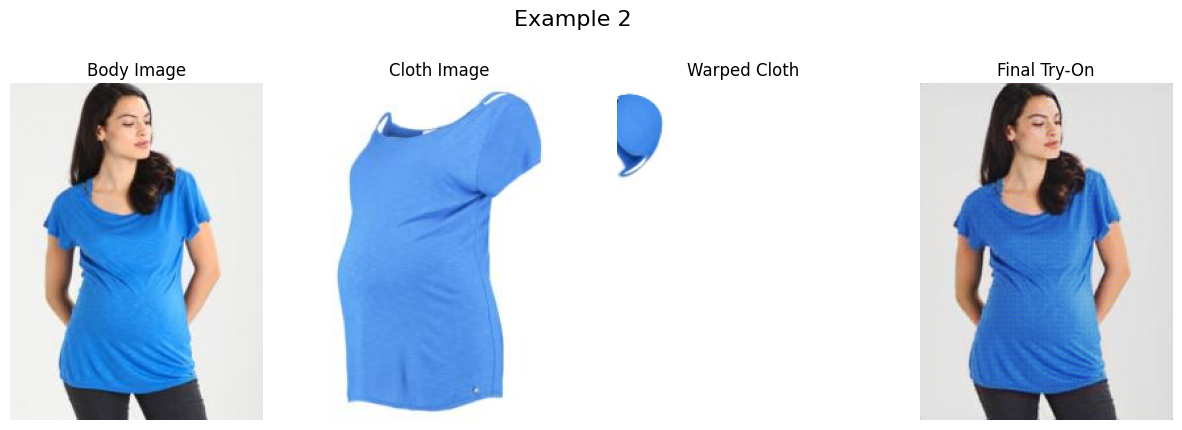

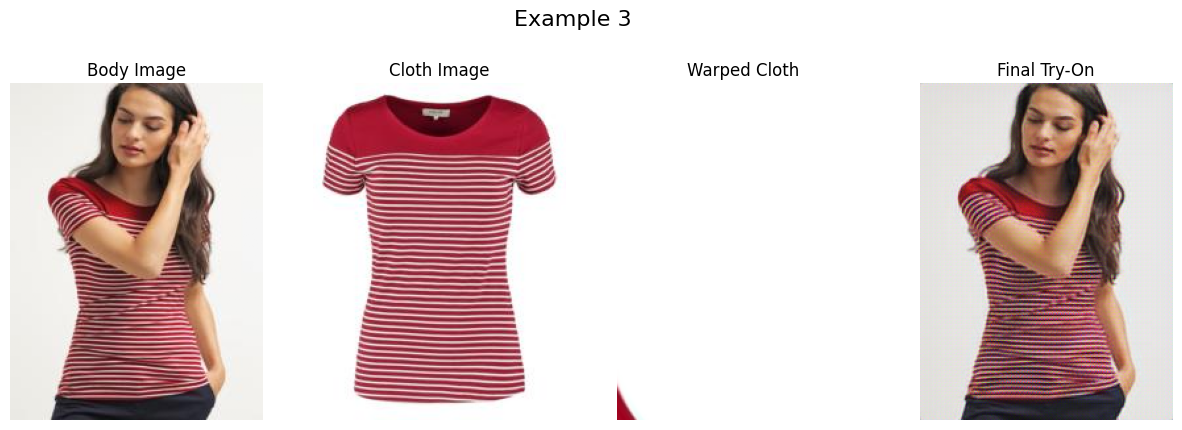

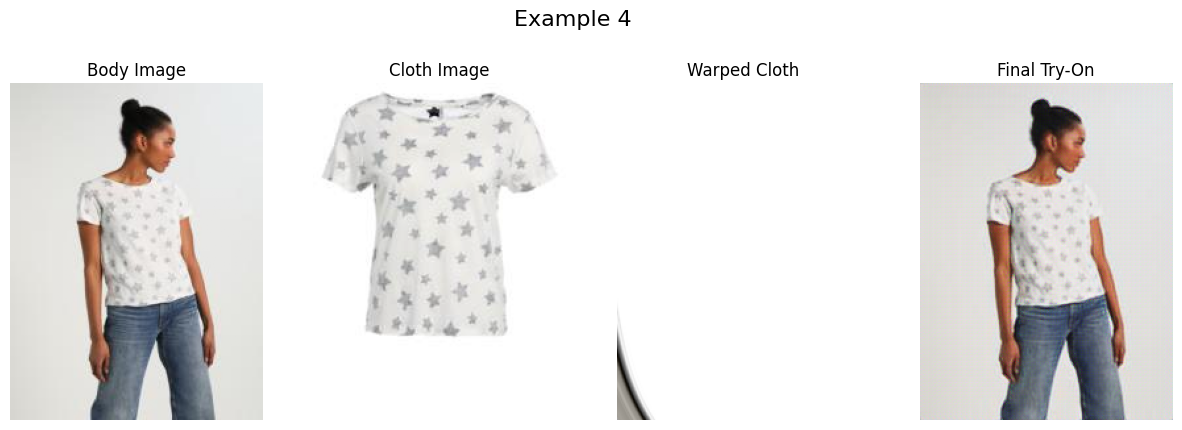

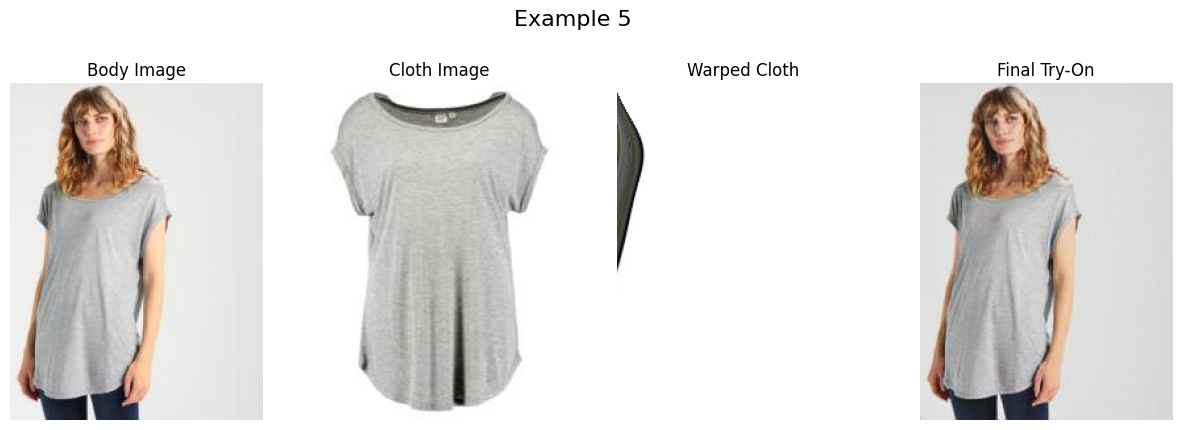

In [192]:
# Visualize results of model
visualize_vton_results(model, test_loader, device=device, num_images=5, save_dir='./model_checkpoints')

## Test models for UI

In [ ]:
# Set models to evaluation mode
gmm.eval()
seg_net.eval()
comp_net.eval()

# Image transformation for preprocessing input images
transform = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


def process_images(body_image_pil, cloth_image_pil):
    """
    Process the body and cloth images using the loaded models to
    produce a composite image.
    """
    # Preprocess input images
    body_image = transform(body_image_pil).unsqueeze(0).to(device)
    cloth_image = transform(cloth_image_pil).unsqueeze(0).to(device)

    # Step 1: Warping the cloth using GMM
    with torch.no_grad():
        warped_cloth = gmm(body_image, cloth_image)

    # Step 2: Generating the segmentation mask using SegNet
    seg_input = torch.cat([body_image, warped_cloth], dim=1)
    with torch.no_grad():
        pred_mask = seg_net(seg_input)

    # Step 3: Composing the final image using CompNet
    with torch.no_grad():
        composite_img = comp_net(body_image, warped_cloth, pred_mask)

    # Convert the output tensor to PIL image
    composite_image = composite_img.squeeze(0).cpu().detach()
    composite_image_pil = transforms.ToPILImage()(composite_image)

    return composite_image_pil

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4434: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4373: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


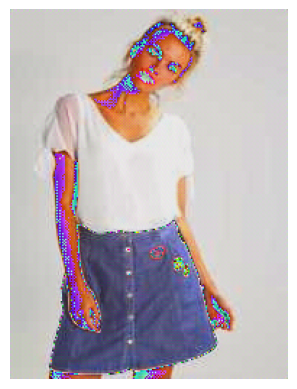

In [ ]:
# Open images with PIL
# Similar body and cloth images
body_image_pil = Image.open('viton_resize/test/image/000020_0.jpg')
cloth_image_pil = Image.open('viton_resize/test/cloth/000020_1.jpg')

# Process the images
processed_image = process_images(body_image_pil, cloth_image_pil)

# Show image
plt.imshow(processed_image)
plt.axis("off")
plt.show()

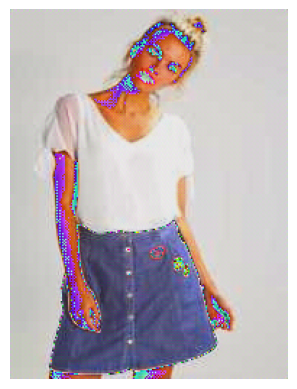

In [ ]:
# Open images with PIL
# Different body and cloth images
body_image_pil = Image.open('./viton_resize/test/image/000020_0.jpg')
cloth_image_pil = Image.open('./viton_resize/test/cloth/000038_1.jpg')

# Process the images
processed_image = process_images(body_image_pil, cloth_image_pil)

# Show image
plt.imshow(processed_image)
plt.axis("off")
plt.show()